# SciPy

## What is SciPy

SciPy stands for (Sci)entific (Py)thon. It is an open-source Python library that contains modules for scientific computing such as linear algrbra, optimization, image/signal processing,, statistics, and many more. SciPy uses the NumPy `array` as it's base data struture, but also builds upon `Pandas`, `Matplotlib`, and `SymPy`.

In [1]:
import numpy as np 
import pandas as pd 
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
import matplotlib.pyplot as plt
from scipy import stats 
from scipy import linalg
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

We will be demonstrating SciPy using the Allen Cell Types Dataset. We will discuss what this dataset contains and how to navigate through it in a later chapter. 

In [2]:
# Download meatadata for only human cells 
human_cells = pd.DataFrame(ctc.get_cells(species=[CellTypesApi.HUMAN])).set_index('id')

# Download electrophysiology data 
ephys_df = pd.DataFrame(ctc.get_ephys_features()).set_index('specimen_id')

# Combine our ephys data with our metadata for human cells 
human_ephys_df = human_cells.join(ephys_df)
human_ephys_df.head()

,reporter_status,cell_soma_location,species,name,structure_layer_name,structure_area_id,structure_area_abbrev,transgenic_line,dendrite_type,apical,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
id,,,,,,,,,,,,,,,,,,,,,
525011903,None,"[273.0, 354.0, 216.0]",Homo Sapiens,H16.03.003.01.14.02,3,12113,FroL,,spiny,intact,...,4.134987,1.375253,-53.968754,-59.510420,-71.197919,2.895461,2.559876,3.099787,-88.843758,-70.561035
528642047,None,"[69.0, 254.0, 96.0]",Homo Sapiens,H16.06.009.01.02.06.05,5,12141,MTG,,aspiny,NA,...,NaN,1.051160,-67.468758,NaN,-70.875002,1.891881,NaN,1.989616,-101.000000,-69.209610
537256313,None,"[322.0, 255.0, 92.0]",Homo Sapiens,H16.03.006.01.05.02,4,12141,MTG,,spiny,truncated,...,5.694547,1.389900,-52.125004,-51.520836,-72.900002,3.121182,3.464528,3.054681,-87.531250,-72.628105
519832676,None,"[79.0, 273.0, 91.0]",Homo Sapiens,H16.03.001.01.09.01,3,12141,MTG,,spiny,truncated,...,9.962780,1.211020,-53.875004,-52.416668,-73.693753,4.574865,3.817988,4.980603,-84.218758,-72.547661
596020931,None,"[66.0, 220.0, 105.0]",Homo Sapiens,H17.06.009.11.04.02,4,12141,MTG,,aspiny,NA,...,14.667340,1.336668,-63.593754,-63.239583,-75.518753,1.452890,1.441754,1.556087,-82.531250,-74.260269


## SciPy for two-sample statistics

In [3]:
# Set up our two samples 
spiny_df = human_ephys_df[human_ephys_df['dendrite_type']== 'spiny']
aspiny_df = human_ephys_df[human_ephys_df['dendrite_type']== 'aspiny']

Most often, the goal of our hypothesis testing is to test whether or not two distributions are different, or if a distribution has a different mean than the underlying population distribution.

If we know our distributions are normal (i.e. they're generated from a normal distribution!) we could use parametric statistics to test our hypothesis. To test for differences between normal populations, we can use the independent t-test in our stats package: `stats.ttest_ind()`. If we had paired samples, we would use a dependent t-test: `stats.ttest_rel()`.


If one of our populations is skewed, however, we cannot use a t-test. A t-test assumes that the populations are normally distributed. For skewed populations, we can use either the Mann-Whitney U (for independent samples: `stats.mannwhitneyu()`) or the Wilcoxon Signed Rank Test (for dependent/paired samples: `stats.wilcoxon()`).

Below we will run a statistical test that compares `aspiny_df['tau']` to `spiny_df['tau']`. Before we decide what test to run, we must first check the skewness of our data. To test for skewness, we can use `stats.skewtest()`. **If the skew test gives us a p-value of less than 0.05, the population is skewed.**

Spiny skew test pvalue: 1.4148485388194806e-12
Aspiny skew test pvalue: 1.1827442418538926e-09


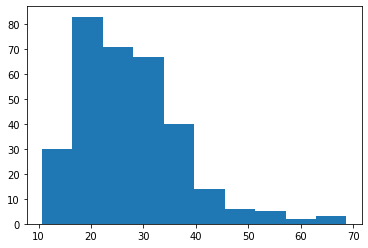

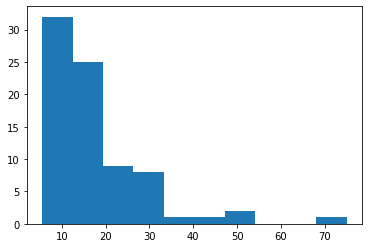

In [4]:
# Subselect our samples 
sample_1 = spiny_df['tau']
sample_2 = aspiny_df['tau']

# Run the skew test
stats_1, pvalue_1 = stats.skewtest(sample_1) 
stats_2, pvalue_2 = stats.skewtest(sample_2)

# Print the p-value of both skew tests
print('Spiny skew test pvalue: ' + str(pvalue_1))
print('Aspiny skew test pvalue: ' + str(pvalue_2))

# Plot our distributions 
plt.hist(sample_1)
plt.show()
plt.hist(sample_2)
plt.show()

Our pvalues indicate that both of our samples are skewed, therefore we will continure with the Mann-Whitney U test. 

In [5]:
print(stats.mannwhitneyu(sample_1, sample_2))

MannwhitneyuResult(statistic=4759.0, pvalue=3.864465154121331e-18)


## SciPy for Linear Algebra

SciPy can be used to find solutions to mathematical algorithms as well. The package has a module with many tools that are helpful with linear algebra. The funtions availabe can help with solving the determinant of a matrix, solve for eigen values, and other liniar algebra problems. After importing the linear algebra module, `linalg` from the SciPy package, it is important to use the syntax `linalg.function()` when executing a function from the module. 

The `linalg.det()` method is used to solve for the the determinant of a matrix. This function only takes in square matrices as an argument, inputting a non-square matrix will result in an error. Please visit <a href = 'https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.det.html'> here</a> for the original documentation. 

In [6]:
# Assign our square matrix
matrix = np.array([[1,3,5,2], [6,3,9,7], [2,7,8,5], [9,4,1,8]])
print(matrix)

[[1 3 5 2]
 [6 3 9 7]
 [2 7 8 5]
 [9 4 1 8]]


In [7]:
print(linalg.det(matrix))

-237.00000000000006


The `linalg.lu()` method is used to solve the LU decomposition of a matrix. It will return the  permutation matrix, p, the lower triangular matrix with unit diagonal elements, l,  and the upper triangular, u. You can look at the <a href = 'https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html' > original documentation</a> for more information. 

In [8]:
# Assign our matrix 
p, l, u = linalg.lu(matrix)
print('Permutation matrix:')
print(p)
print('\n')
print('Lower triangular:')
print(l)
print('\n')
print('Upper Triangle')
print(u)

Permutation matrix:
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


Lower triangular:
[[1.         0.         0.         0.        ]
 [0.22222222 1.         0.         0.        ]
 [0.66666667 0.05454545 1.         0.        ]
 [0.11111111 0.41818182 0.20689655 1.        ]]


Upper Triangle
[[ 9.          4.          1.          8.        ]
 [ 0.          6.11111111  7.77777778  3.22222222]
 [ 0.          0.          7.90909091  1.49090909]
 [ 0.          0.          0.         -0.54482759]]


Now that we have p, l, and u, we can used a funtion from numpy, `np.dot()` to execute the dot product of l and u to return our matrix. 

In [9]:
print(np.dot(l,u))

[[9. 4. 1. 8.]
 [2. 7. 8. 5.]
 [6. 3. 9. 7.]
 [1. 3. 5. 2.]]


You can also find the eigen values and eigen vectors with SciPy. The method `linalg.eig()` takes in a complex or real matrix and returns its eigenvalues. Please visit <a href = 'https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eig.html'> here</a> for the orignal documentation.

In [10]:
eigen_values, eigen_vectors = linalg.eig(matrix) 
print(eigen_values)
print('\n')
print(eigen_vectors) 

[20.15126564+0.j          1.64808546+0.83387563j  1.64808546-0.83387563j
 -3.44743656+0.j        ]


[[-2.94498514e-01+0.j         -4.63909706e-01+0.08050438j
  -4.63909706e-01-0.08050438j -2.00900213e-04+0.j        ]
 [-5.98355615e-01+0.j         -1.69258696e-01+0.00537595j
  -1.69258696e-01-0.00537595j -8.69603794e-01+0.j        ]
 [-5.83737468e-01+0.j         -2.96214773e-01-0.07015942j
  -2.96214773e-01+0.07015942j  4.14828984e-01+0.j        ]
 [-4.63132542e-01+0.j          8.10533088e-01+0.j
   8.10533088e-01-0.j          2.67779977e-01+0.j        ]]


Lastly, SciPy can be used to solve linear systems of equations. Please visit <a href = 'https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html'> here</a> for the orignal documentation.

In [11]:
array = [[2],[4],[6],[8]]
print(linalg.solve(matrix, array))

[[ 0.04219409]
 [ 0.76793249]
 [-0.31223629]
 [ 0.60759494]]


## SciPy for FFT

## Additional Resources